In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import mean
from sklearn.metrics import mean_squared_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.api import ExponentialSmoothing
from matplotlib import pyplot
import warnings
import itertools
from pandas import DataFrame

In [3]:
df=pd.read_csv("world_cases.csv")
df['date']=pd.to_datetime(df['date'], infer_datetime_format=True)
df.head()

,date,World
0,2019-12-31,27
1,2020-01-01,0
2,2020-01-02,0
3,2020-01-03,17
4,2020-01-04,0


In [4]:
df.tail()

,date,World
330,2020-11-25,561704
331,2020-11-26,649666
332,2020-11-27,549900
333,2020-11-28,616139
334,2020-11-29,552296


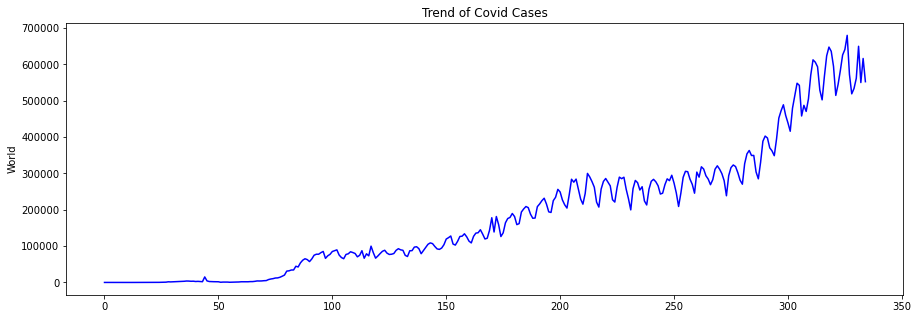

In [5]:
plt.figure(figsize=(15,5))
plt.ylabel('World')
plt.title('Trend of Covid Cases')
plt.plot(df['World'],'b-');

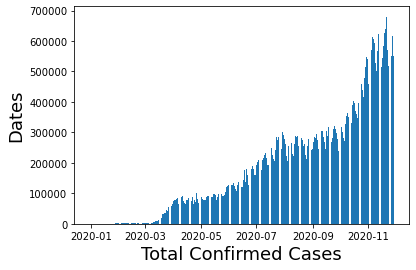

In [6]:
plt.style.use=('bmh')
x=df['date']
y=df['World']
plt.bar(x,y)
plt.xlabel("Total Confirmed Cases", fontsize=18)
plt.ylabel("Dates",fontsize=18)
plt.show()

In [7]:
df=df.set_index(['date'])

# Checking stationarity

In [8]:
#Test 1: Augmented Dickey Fuller Test:
X = df['World'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.113226
p-value: 0.709769
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


In [9]:
#Outcome: the p value is greater than 0.05, thus we fail to reject the Null Hypothesis. Therefore, the series has a unit root and is non stationary.

In [10]:
#Test 2 : KPSS Test
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
kpss_test(df['World'].values)

Results of KPSS Test:
Test Statistic            1.776466
p-value                   0.010000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\MUSKAN\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [11]:
#Outcome: Here, the p value is less than 0.05. However, the Null Hypothesis of KPSS test is opposite of the ADF test. Thus here, we will reject the Null Hypothesis of stationary series and conclude that the series is non stationary.

In [12]:
#making Series stationary using seasonal differencing of order 1 
df['World_diff'] = df['World'] - df['World'].shift(12)
df[['World','World_diff']].head(13)

,World,World_diff
date,,
2019-12-31,27,NaN
2020-01-01,0,NaN
2020-01-02,0,NaN
2020-01-03,17,NaN
2020-01-04,0,NaN
2020-01-05,15,NaN
2020-01-06,0,NaN
2020-01-07,0,NaN
2020-01-08,0,NaN


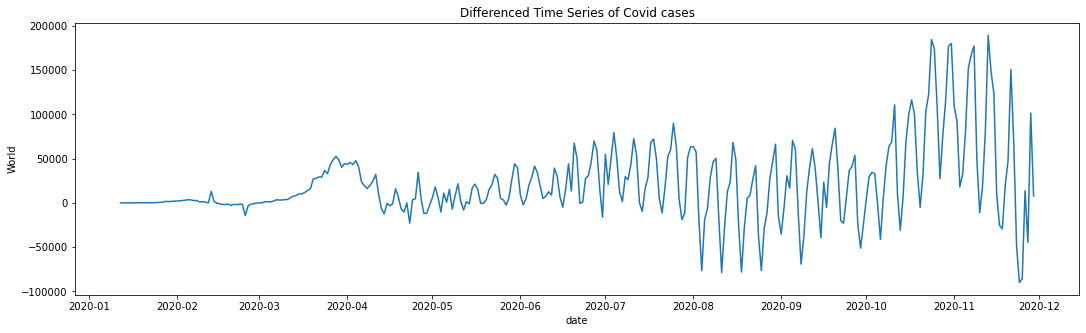

In [13]:
plt.figure(figsize=(18,5));
plt.xlabel('date');
plt.ylabel('World');
plt.title('Differenced Time Series of Covid cases');
plt.plot(df['World_diff']);

In [14]:
# ADF Test: 
X = df['World_diff'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.978852
p-value: 0.036917
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [15]:
#the p value is less than 0.05. Thus, we will reject the Null Hypothesis and conclude that the series is stationary.

In [16]:
# KPSS Test 
kpss_test(X)

Results of KPSS Test:
Test Statistic            0.580852
p-value                   0.024377
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [17]:
#The p value of the KPSS test is less than 0.05. Thus, we will reject the null hypothesis that the series is stationary. The KPSS test concludes that the series is non stationary.

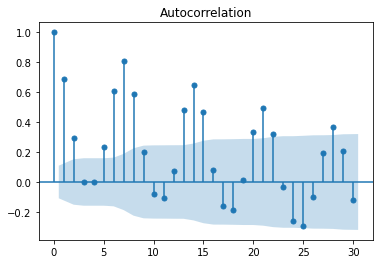

In [18]:
acf_plot = plot_acf(df['World_diff'].dropna(), lags= 30)

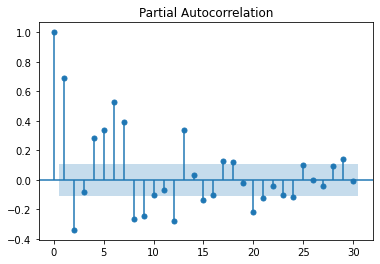

In [19]:
pacf_plot = plot_pacf(df['World_diff'].dropna(), lags= 30)

In [20]:
#difference the series once again to make it stationary. This will be non seasonal difference of order 1 i.e. d = 1

In [21]:
df['World_diff2'] = df['World_diff'] - df['World_diff'].shift(1)

In [22]:
# ADF Test 
X = df['World_diff2'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.404285
p-value: 0.010814
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


In [23]:
#the p value is less than 0.05. Thus, we will reject the Null Hypothesis and conclude that the series is stationary.

In [24]:
# KPSS Test:
kpss_test(X)

Results of KPSS Test:
Test Statistic            0.026859
p-value                   0.100000
Lags Used                17.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\MUSKAN\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [25]:
#The p value of the KPSS test is less than 0.05. Thus, we will accept the null hypothesis that the series is stationary.

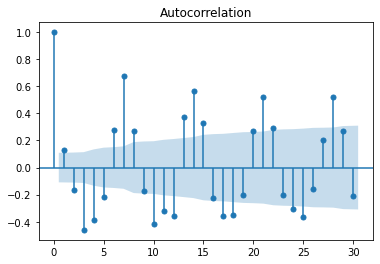

In [26]:
acf_plot = plot_acf(df['World_diff2'].dropna(), lags= 30)

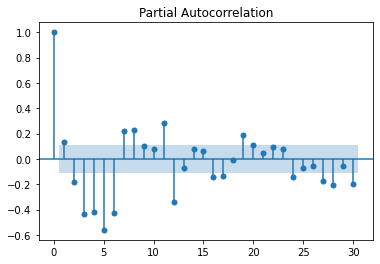

In [27]:
pacf_plot = plot_pacf(df['World_diff2'].dropna(), lags= 30)

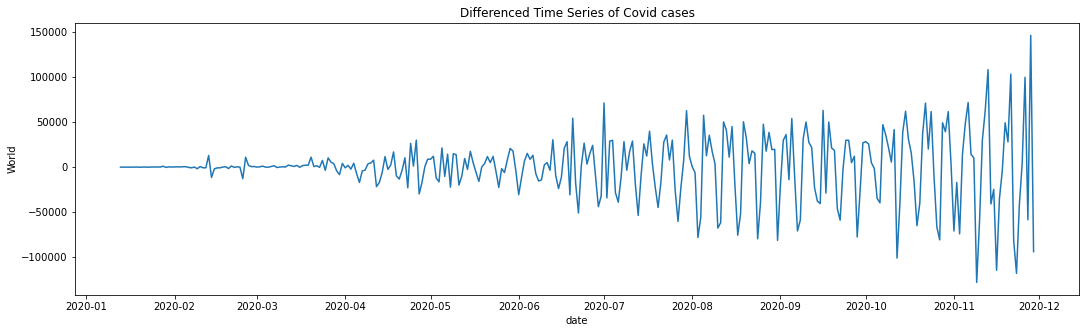

In [28]:
plt.figure(figsize=(18,5));
plt.xlabel('date');
plt.ylabel('World');
plt.title('Differenced Time Series of Covid cases');
plt.plot(df['World_diff2']);

In [29]:
import pmdarima as pm
from pmdarima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")
df1 = df['World']
df1.head()

date
2019-12-31    27
2020-01-01     0
2020-01-02     0
2020-01-03    17
2020-01-04     0
Name: World, dtype: int64

In [30]:
model = auto_arima(df1, start_p=0, start_q=0,
                          max_p=2, max_q=2,m=12,start_P=0,start_Q=0, 
                          max_P = 2, max_Q = 2,
                          seasonal=True,
                          d=1,D=1,trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=7645.105, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=7579.838, Time=0.43 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=7641.305, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=1.52 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=7495.706, Time=0.71 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=1.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=7455.752, Time=2.17 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=7456.241, Time=2.93 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=inf, Time=2.61 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=7369.833, Time=1.77 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.45 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=7424.163, Time=0.79 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=7385.943, Time=1.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=7

In [31]:
#Auto Arima gives (0,1,0)(2,1,2)12 as the best model i.e. the model with the least AIC.

In [32]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  335
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -3680.917
Date:                              Sun, 28 Nov 2021   AIC                           7369.833
Time:                                      20:12:24   BIC                           7384.932
Sample:                                           0   HQIC                          7375.861
                                              - 335                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4566      0.054     -8.521      0.000      -0.562      -0.352
ar.S.L24      -0.64

start=len(train)
end=len(train)+len(test)-1
train=np.array(train,dtype=np.float)
final_model = ARIMA(train,order=(0,1,0))
#train = train.astype('float32')
result = final_model.fit()
print(result.summary())
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels')

In [33]:
#data is divided into trainin and testing data in 80:20 ratio
train = df1[:268]
test = df1[268:]
from statsmodels.tsa.statespace.sarimax import SARIMAX
final_model = SARIMAX(train,order=(0,1,0),seasonal_order=(2,1,1,12))
result = final_model.fit()
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                World   No. Observations:                  268
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood               -2814.193
Date:                              Sun, 28 Nov 2021   AIC                           5636.385
Time:                                      20:12:26   BIC                           5650.550
Sample:                                  12-31-2019   HQIC                          5642.083
                                       - 09-23-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.4887      0.085     -5.742      0.000      -0.656      -0.322
ar.S.L24      -0.55

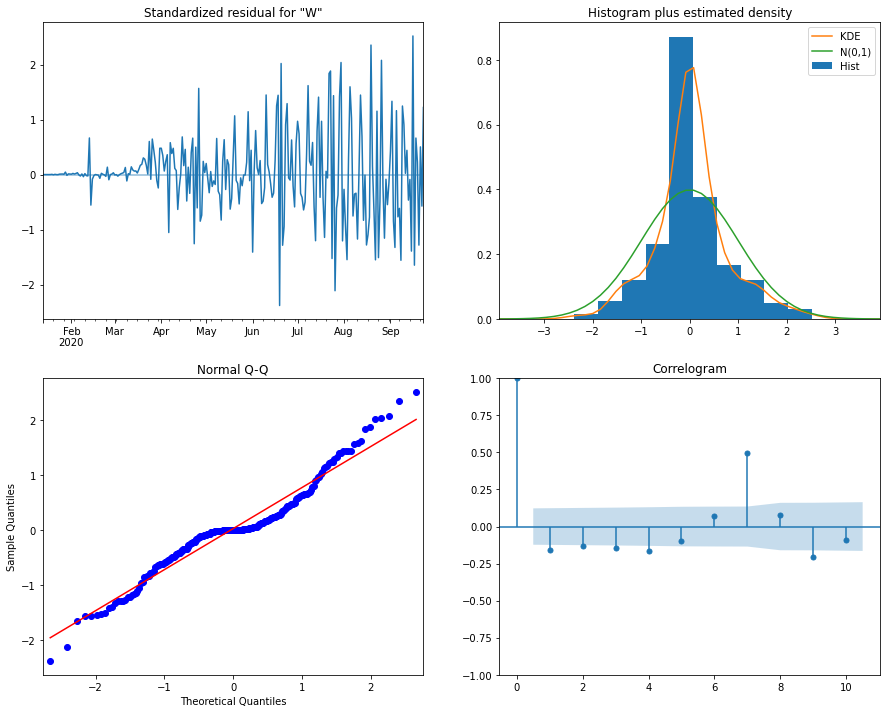

In [34]:
#model diagnostics to check for the assumptions of normality of errors and the distribution of residuals. 
result.plot_diagnostics(figsize=(15, 12));

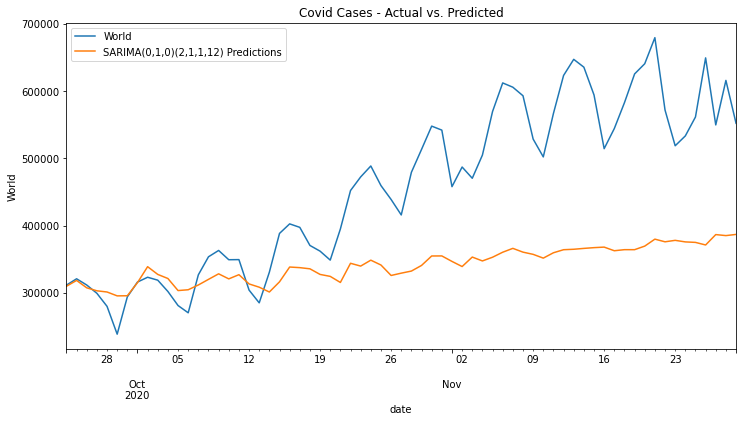

In [35]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = result.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0,1,0)(2,1,1,12) Predictions')
# Plot predictions against known values
title = 'Covid Cases - Actual vs. Predicted'
ylabel='World'
xlabel='date'

ax = test.plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
plt.show()

In [36]:
print(predictions)

2020-09-24    309758.871559
2020-09-25    318450.646766
2020-09-26    307434.683607
2020-09-27    303015.754381
2020-09-28    301236.409606
                  ...      
2020-11-25    375055.527949
2020-11-26    371203.793641
2020-11-27    386678.851061
2020-11-28    385159.953264
2020-11-29    386924.603264
Freq: D, Name: SARIMA(0,1,0)(2,1,1,12) Predictions, Length: 67, dtype: float64


In [37]:
test.mean()

455953.05970149254

In [39]:
#for checking accuracy
from sklearn.metrics import mean_squared_error
from math import sqrt
mse=mean_squared_error(predictions,test)
print(mse)
rmse=sqrt(mean_squared_error(predictions,test))
print(rmse)

22983394801.39202
151602.75327774236


In [35]:
pip show statsmodels

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: c:\users\muskan\anaconda3\lib\site-packages
Requires: numpy, scipy, pandas, patsy
Required-by: pmdarima
Note: you may need to restart the kernel to use updated packages.


In [36]:
conda update statsmodels

Solving environment: ...working... 

Updating statsmodels is constricted by 

anaconda -> requires statsmodels==0.12.2=py38h2bbff1b_0

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [38]:
#prediction
future_dates=pd.date_range(start='2020-11-29', end='2020-12-28')
#print(index_future_dates)
df=df.astype('float32')
pred=result.predict(start=len(df),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#model_fit = model.fit(disp=0)
#print(comp_pred)
#pred.index=index_future_dates
print(pred)

2020-11-30    383228.243446
2020-12-01    374194.038829
2020-12-02    379193.887646
2020-12-03    386441.101113
2020-12-04    389464.591485
2020-12-05    397845.992807
2020-12-06    396406.320246
2020-12-07    391448.522708
2020-12-08    385153.547617
2020-12-09    400825.549107
2020-12-10    396796.569642
2020-12-11    401131.532034
2020-12-12    403275.106821
2020-12-13    401847.778296
2020-12-14    400915.878154
2020-12-15    402107.652037
2020-12-16    400794.717370
2020-12-17    409367.454041
2020-12-18    411311.276825
2020-12-19    409196.405103
2020-12-20    406953.719739
2020-12-21    414548.496290
2020-12-22    413036.288315
2020-12-23    412130.249559
2020-12-24    414361.400542
2020-12-25    414228.420395
2020-12-26    416363.834883
2020-12-27    422246.053392
2020-12-28    419182.488787
2020-12-29    424208.409843
2020-12-30    424010.207128
Freq: D, Name: ARIMA Predictions, dtype: float64


In [41]:
model_autoARIMA = auto_arima(train, start_p=0, start_q=0,test='kpss', max_p=3, max_q=3,m=1,d=None,seasonal=False,start_P=0, D=0,trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5919.927, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5917.953, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5916.341, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5919.145, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5891.243, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5847.536, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5907.030, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5810.027, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5870.054, Time=0.08 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5930.026, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5823.257, Time=0.16 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 2.672 seconds
                               SARIMAX Results                                
Dep. Variable: